In [1]:
import numpy as np
import numpy.linalg as npla
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 14,
})

from pylgmath import se3op, Transformation

from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.stereo import HomoPointStateVar, ComposeLandmarkEvaluator, HomoPointErrorEvaluator
from pysteam.problem import OptimizationProblem, L2LossFunc, StaticNoiseModel, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver, Covariance
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as ConstVelTrajectory

In [2]:
T_robot_lidar = np.array([[ 0.68297386,  0.73044281,  0.        ,  0.466],
                          [-0.73044281,  0.68297386,  0.        ,  0.  ],
                          [ 0.        ,  0.        ,  1.        , -0.21],
                          [ 0.        ,  0.        ,  0.        ,  1.  ]])
print(npla.inv(T_robot_lidar))
se3op.tran2vec(npla.inv(T_robot_lidar)).flatten()

print(T_robot_lidar)

print(T_robot_lidar[[0,3], [1,2]])

[[ 0.682974 -0.730443 -0.       -0.318266]
 [ 0.730443  0.682974  0.       -0.340386]
 [ 0.        0.        1.        0.21    ]
 [ 0.        0.        0.        1.      ]]
[[ 0.682974  0.730443  0.        0.466   ]
 [-0.730443  0.682974  0.        0.      ]
 [ 0.        0.        1.       -0.21    ]
 [ 0.        0.        0.        1.      ]]
[0.730443 0.      ]


In [3]:
def plot_frame(ax, T_ri=np.eye(4), length=1, **kwargs):
  axes = T_ri @ np.concatenate((np.eye(3) * length, np.ones((1, 3))), axis=0)
  ax.plot(*zip(T_ri[:3, 3], axes[:3, 0]), color='r', **kwargs)
  ax.plot(*zip(T_ri[:3, 3], axes[:3, 1]), color='g', **kwargs)
  ax.plot(*zip(T_ri[:3, 3], axes[:3, 2]), color='b', **kwargs)

def get_cov_ellipsoid(ax, mu, cov, nstd=3, **kwargs):
  assert mu.shape == (3,) and cov.shape == (3, 3)

  # Find and sort eigenvalues to correspond to the covariance matrix
  eigvals, eigvecs = np.linalg.eigh(cov)
  idx = np.sum(cov, axis=0).argsort()
  eigvals_temp = eigvals[idx]
  idx = eigvals_temp.argsort()
  eigvals = eigvals[idx]
  eigvecs = eigvecs[:, idx]

  # Set of all spherical angles to draw our ellipsoid
  n_points = 100
  theta = np.linspace(0, 2 * np.pi, n_points)
  phi = np.linspace(0, np.pi, n_points)

  # Width, height and depth of ellipsoid
  rx, ry, rz = nstd * np.sqrt(eigvals)

  # Get the xyz points for plotting
  # Cartesian coordinates that correspond to the spherical angles:
  X = rx * np.outer(np.cos(theta), np.sin(phi))
  Y = ry * np.outer(np.sin(theta), np.sin(phi))
  Z = rz * np.outer(np.ones_like(theta), np.cos(phi))

  # Rotate ellipsoid for off axis alignment
  old_shape = X.shape
  # Flatten to vectorise rotation
  X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
  X, Y, Z = np.matmul(eigvecs, np.array([X, Y, Z]))
  X, Y, Z = X.reshape(old_shape), Y.reshape(old_shape), Z.reshape(old_shape)

  # Add in offsets for the mean
  X = X + mu[0]
  Y = Y + mu[1]
  Z = Z + mu[2]

  return ax.plot_wireframe(X, Y, Z, **kwargs)

In [4]:
## setup
# number of node states along trajectory (make as large as you like)
K = 10
# total arclength
L = 10

# initialize the node states (pose and velocity)
t_list = []
gt_w_ir_inr_list = []
gt_T_ri_list = []
w_ir_inr_list = []
T_ri_list = []
for i in range(K):
  # time (time along the trajectory from start to end)
  t_list.append(i * L / (K - 1))

  # ground truth trajectory
  if i == 0:
    gt_w_ir_inr_list.append(np.array([[-1., 0., 0., 0., 0., 0.]]).T)
    gt_T_ri_list.append(np.eye(4))
  else:
    gt_w_ir_inr_list.append(np.array([[-1., 0., 0., 0., .1, .3]]).T)
    gt_T_ri_list.append(se3op.vec2tran(L / (K - 1) * gt_w_ir_inr_list[i - 1]) @ gt_T_ri_list[i - 1])

  # initial trajectory
  w_ir_inr_list.append(np.array([[-1., 0., 0., 0., 0., 0.]]).T)
  T_ri_list.append(np.array([[1., 0., 0., -t_list[-1]], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]]))

# landmarks
Jland = 5

# true landmarks
gt_p_list = [
  np.array([[3.,  -1.,  1.,  1.]]).T,
  np.array([[0.,  -1.,  2.,  1.]]).T,
  np.array([[1.,  -4.,  2.,  1.]]).T,
  np.array([[2.,  -3.,  2.,  1.]]).T,
  np.array([[1.,  -3., -2.,  1.]]).T,
]

# initial landmarks
p_list = [np.array([[0.,  0.,  0.,  1.]]).T for _ in range(Jland)]

# set up the problem
t_knot_list = [Time(t) for t in t_list]
w_ir_inr_var_list = [VSpaceStateVar(w_ir_inr) for w_ir_inr in w_ir_inr_list]
T_ri_var_list = [SE3StateVar(Transformation(T_ba=T_ri)) for T_ri in T_ri_list]
p_var_list = [HomoPointStateVar(p) for p in p_list]

Qc = 0.01 * np.diag([0.1, 0.001, 0.001, 0.01, 0.01, 0.01])
trajectory = ConstVelTrajectory(Qc_inv=npla.inv(Qc))
for (t, T_ri, w_ir_inr) in zip(t_knot_list, T_ri_var_list, w_ir_inr_var_list):
  trajectory.add_knot(time=t, T_k0=T_ri, w_0k_ink=w_ir_inr)

meas_cost_terms = []
noise_model = StaticNoiseModel(0.01 * np.eye(3))
loss_func = L2LossFunc()
for k in range(K):
  j = k % Jland
  y = gt_T_ri_list[k] @ gt_p_list[j]
  error_func = HomoPointErrorEvaluator(ComposeLandmarkEvaluator(T_ri_var_list[k], p_var_list[j]), y)
  meas_cost_terms.append(WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

w_ir_inr_var_list[0].locked = True
T_ri_var_list[0].locked = True

opt_prob = OptimizationProblem()
opt_prob.add_state_var(*w_ir_inr_var_list, *T_ri_var_list, *p_var_list)
opt_prob.add_cost_term(*trajectory.get_prior_cost_terms())
opt_prob.add_cost_term(*meas_cost_terms)

solver = GaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()


Begin Optimization
------------------
Number of States:  23
Number of Cost Terms:  19
Initial Cost:  22543.89639357036
Iteration:    1  -  Cost: 15787.7606
Iteration:    2  -  Cost: 63483.9838
Iteration:    3  -  Cost:   357.7227
Iteration:    4  -  Cost:   126.0750
Iteration:    5  -  Cost:   125.7988
Iteration:    6  -  Cost:   125.7984
Termination Cause:  CONVERGED RELATIVE CHANGE
Total Optimization Time: 0.3894 seconds


In [5]:
# query estimated trajectory
tq_list = np.linspace(0.0, L, 100)
w_ir_inr_q_list = [trajectory.get_velocity_interpolator(Time(tq)).evaluate() for tq in tq_list]
T_ri_q_list = [trajectory.get_pose_interpolator(Time(tq)).evaluate() for tq in tq_list]
rq = np.stack([T_ri_q.inverse().matrix()[:3, 3] for T_ri_q in T_ri_q_list]).T

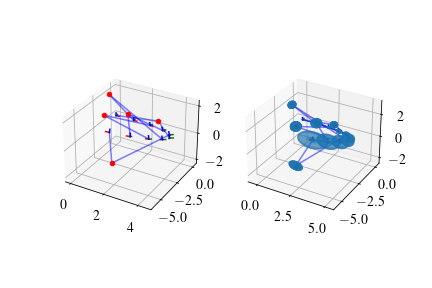

In [6]:
fig = plt.figure()

# ground truth
ax = fig.add_subplot(1, 2, 1, projection='3d')
for gt_p in gt_p_list:
  ax.scatter(*gt_p[:3, 0], color='r')
for gt_T_ri in gt_T_ri_list:
  plot_frame(ax, npla.inv(gt_T_ri), length=0.2)

gt_r_list = [npla.inv(gt_T_ri)[:3, 3] for gt_T_ri in gt_T_ri_list]
gt_p_list = [gt_p[:3, 0] for gt_p in gt_p_list]
for k in range(K):
  ax.plot(*np.stack((gt_r_list[k], gt_p_list[k % Jland])).T, color='b', alpha=0.5)

# estimated
ax = fig.add_subplot(1, 2, 2, projection='3d')
for p in p_var_list:
  ax.scatter(*p.evaluate()[:3, 0], color='r')
for T_ri_var in T_ri_var_list:
  plot_frame(ax, npla.inv(T_ri_var.evaluate().matrix()), length=0.2)

ax.plot(*rq)

r_list = [npla.inv(T_ri_var.evaluate().matrix())[:3, 3] for T_ri_var in T_ri_var_list]
p_list = [p.evaluate()[:3, 0] for p in p_var_list]
for k in range(K):
  ax.plot(*np.stack((r_list[k], p_list[k % Jland])).T, color='b', alpha=0.5)

covariance = Covariance(opt_prob)

for T_ri_var in T_ri_var_list[1:]:
  T_ir = npla.inv(T_ri_var.evaluate().matrix())
  Ad_T_ir = se3op.tranAd(T_ir)
  T_ir_cov = Ad_T_ir @ covariance.query(T_ri_var) @ Ad_T_ir.T
  r_cov = T_ir_cov[:3, :3]
  get_cov_ellipsoid(ax, T_ir[:3, 3], r_cov, alpha=0.1)

p_cov_list = [covariance.query(p_var) for p_var in p_var_list]
for k in range(K):
  get_cov_ellipsoid(ax, p_list[k % Jland], p_cov_list[k % Jland], alpha=0.1)
